# Task
Use any financial ticker (except S&P500) to create the trading strategy, using KNN classifier.

---
Upload data for one ticker (for the recent year) from Yahoo Finance. Make brief exploratory analysis of obtained data.Apply KNN classifier to obtained data. Assess the quality of the model. Create and briefly justify the trading strategy.

Hint. Use [this material](https://blog.quantinsti.com/machine-learning-k-nearest-neighbors-knn-algorithm-python/) to start your own calculations. [This link](https://pypi.org/project/fix-yahoo-finance/0.1.30/) with library fixes might be helpful.

In [4]:
#I chose DIA ticker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pandas_datareader import data as pdr
import yfinance as yf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#getting tha data for the recent year
df= pdr.get_data_yahoo('DIA', '2019-12-12', '2020-12-12')
df = df.dropna()
df = df[['Open', 'High', 'Low','Close']]
df

,Open,High,Low,Close
Date,,,,
2019-12-12,279.519989,282.950012,279.239990,281.950012
2019-12-13,281.929993,283.609985,281.000000,282.109985
2019-12-16,282.929993,284.109985,282.929993,283.070007
2019-12-17,283.190002,284.000000,282.910004,283.399994
2019-12-18,283.790009,283.910004,283.149994,283.209991
...,...,...,...,...
2020-12-07,301.769989,302.160004,300.000000,301.100006
2020-12-08,300.010010,302.869995,299.980011,302.200012
2020-12-09,303.220001,303.600006,299.970001,300.880005


In [5]:
df.describe()

,Open,High,Low,Close
count,253.000000,253.000000,253.000000,253.000000
mean,268.165021,270.280711,265.837036,268.124388
std,24.376181,23.312899,25.343420,24.284169
min,190.130005,191.199997,182.100006,186.130005
25%,255.070007,257.940002,252.059998,255.910004
50%,275.000000,277.070007,273.290009,274.660004
75%,286.220001,287.029999,284.850006,285.929993
max,303.220001,303.600006,300.600006,302.589996


The data obtained consists an information about 253 business days over the last year ended 12.12.20. There are open and close prices with highest and lowest values observed per day.
– min open and close prices were 190 nd 186 respectively<br>
– max open and close were 303 and 302<br>
– standard deviation for both ndicators is about 25<br>
– median value is a little bit higher than average – 275 VS 268 (open and close median), 274 VS 268 (open and close average)

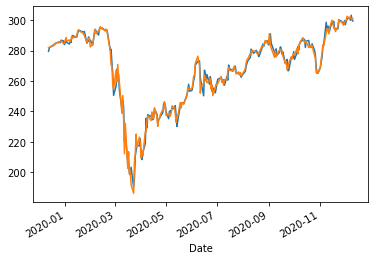

In [6]:
df['Open'].plot()
df['Close'].plot()

The significant and fast drop in numbers was observed when the pandemic-related restictions entered into force.
This decline took a place in March-April. After that a gradual growth was going till September when and it reached its previous indicator. To sum up, since 2nd quarter of 2020 there was in general positive trend.

In [7]:
# Predictor variables
df['Open-Close']= df.Open -df.Close
df['High-Low']  = df.High - df.Low
df =df.dropna()
X= df[['Open-Close', 'High-Low']]
X

,Open-Close,High-Low
Date,,
2019-12-12,-2.430023,3.710022
2019-12-13,-0.179993,2.609985
2019-12-16,-0.140015,1.179993
2019-12-17,-0.209991,1.089996
2019-12-18,0.580017,0.760010
...,...,...
2020-12-07,0.669983,2.160004
2020-12-08,-2.190002,2.889984
2020-12-09,2.339996,3.630005


In [15]:
#Target variable

#The stategy is that if the tomorrow’s closing price is greater than today’s closing price 
#we buy DIA, else we will sell 
#+1 for the buy signal and -1 for the sell signal
Y= np.where(df['Close'].shift(-1)>df['Close'],1,-1)

# Splitting the dataset
split_percentage = 0.8
split = int(split_percentage*len(df))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

# Instantiate KNN learning model and fit the model
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train, Y_train)

# Accuracy Score
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print ('Train_data Accuracy: {:.2f}'.format(accuracy_train))
print ('Test_data Accuracy: {:.2f}'.format(accuracy_test))

Train_data Accuracy: 0.59
Test_data Accuracy: 0.59


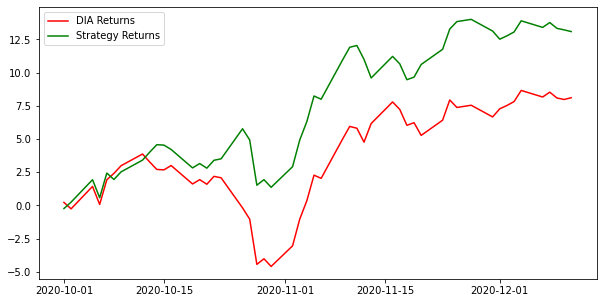

In [16]:
# Predicted Signal
df['Predicted_Signal'] = knn.predict(X)

# DIA Cumulative Returns
df['DIA_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_DIA_returns = df[split:]['DIA_returns'].cumsum()*100

# Cumulative Strategy Returns 
df['Startegy_returns'] = df['DIA_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = df[split:]['Startegy_returns'].cumsum()*100

# Plot the results to visualize the performance
plt.figure(figsize=(10,5))
plt.plot(Cumulative_DIA_returns, color='r',label = 'DIA Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In [19]:
DiaMeanRet=Cumulative_DIA_returns.mean()
StrMeanRet=Cumulative_Strategy_returns.mean()

In [20]:
print('Over the last year ended 12.12.20 the average cumulative DIA return was about {:.2f}% and cumulative strategy returns in the same period are around {:.2f}%'.format(DiaMeanRet, StrMeanRet))

Over the last year ended 12.12.20 the average cumulative DIA return was about 3.70% and cumulative strategy returns in the same period are around 7.53%


In [21]:
#Sharpe ratio calculation
Std = Cumulative_Strategy_returns.std()
Sharpe = (Cumulative_Strategy_returns-Cumulative_DIA_returns)/Std
Sharpe = Sharpe.mean()
print('Sharpe ratio: {:.2f} which is considered as sub-optimal/quite poor as it is lower than 1.'.format(Sharpe))

Sharpe ratio: 0.80 which is considered as sub-optimal/quite poor as it is lower than 1.
